<a href="https://colab.research.google.com/github/hafsaAit/Time-Series-Models-JOURNALIERS-/blob/main/TIME_SERIES_MODELS_(JOURNALIERS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### packages

In [1]:
!pip install pmdarima

In [2]:
pip install sktime

In [3]:
!pip install prophet

In [ ]:
pip install feature_engine

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from pandas import date_range
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


### DATA FRAME

In [6]:
df = pd.read_excel("/content/drive/MyDrive/stage/data (journaliers)/RAIB ET LBEN JOURNALIERS.xlsx")

print(df)
print(df.columns)


     Jour Fiscal  Ventes Totales TTC
0     2011/12/14               35770
1     2011/12/15               51009
2     2011/12/16               97948
3     2011/12/17               36931
4     2011/12/18               32585
...          ...                 ...
4180  2023/06/21               85658
4181  2023/06/22              119798
4182  2023/06/23              183712
4183  2023/06/24              114690
4184  2023/06/25                   0

[4185 rows x 2 columns]
Index(['Jour Fiscal', 'Ventes Totales TTC'], dtype='object')


In [7]:
df['Jour Fiscal'] = pd.to_datetime(df['Jour Fiscal'])


In [8]:
df.set_index('Jour Fiscal', inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4185 entries, 2011-12-14 to 2023-06-25
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Ventes Totales TTC  4185 non-null   int64
dtypes: int64(1)
memory usage: 65.4 KB


In [10]:
df

,Ventes Totales TTC
Jour Fiscal,
2011-12-14,35770
2011-12-15,51009
2011-12-16,97948
2011-12-17,36931
2011-12-18,32585
...,...
2023-06-21,85658
2023-06-22,119798
2023-06-23,183712


In [11]:
df = df.asfreq('D')

In [12]:
df

,Ventes Totales TTC
Jour Fiscal,
2011-12-14,35770.0
2011-12-15,51009.0
2011-12-16,97948.0
2011-12-17,36931.0
2011-12-18,32585.0
...,...
2023-06-21,85658.0
2023-06-22,119798.0
2023-06-23,183712.0


In [13]:
df['Ventes Totales TTC'] = df['Ventes Totales TTC'].replace(0, float('nan'))


In [14]:
df['Ventes Totales TTC'] = df['Ventes Totales TTC'].fillna(method='ffill')

<ipython-input-14-f90f1f41f502>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Ventes Totales TTC'] = df['Ventes Totales TTC'].fillna(method='ffill')


In [15]:
df

,Ventes Totales TTC
Jour Fiscal,
2011-12-14,35770.0
2011-12-15,51009.0
2011-12-16,97948.0
2011-12-17,36931.0
2011-12-18,32585.0
...,...
2023-06-21,85658.0
2023-06-22,119798.0
2023-06-23,183712.0


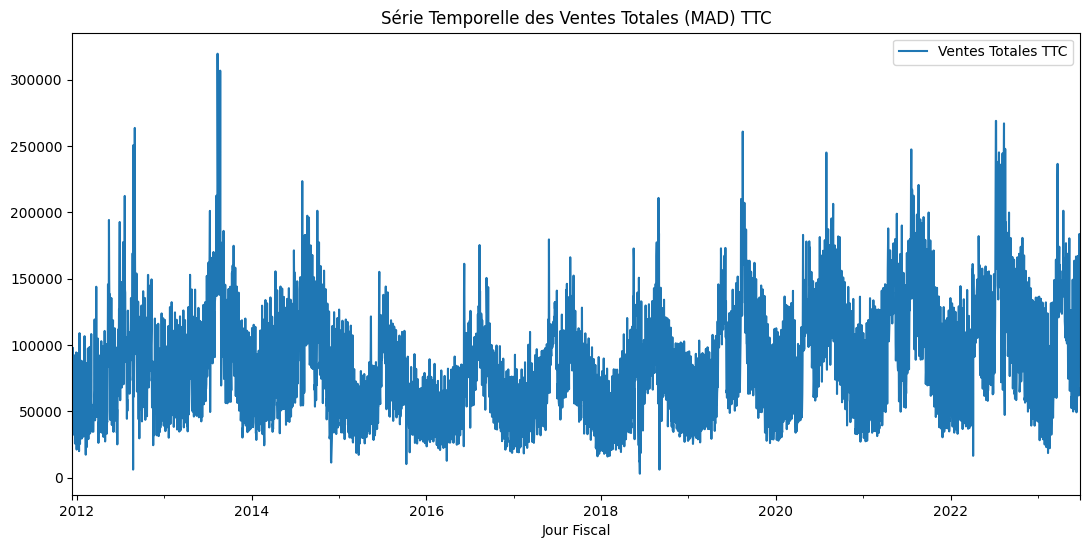

In [16]:
df.plot(y='Ventes Totales TTC', figsize=(13, 6))
plt.title('Série Temporelle des Ventes Totales (MAD) TTC')
plt.show()


In [17]:
date_fin_train = '2022-10-01'
df_train = df[df.index < date_fin_train]
df_test = df[df.index >= date_fin_train]

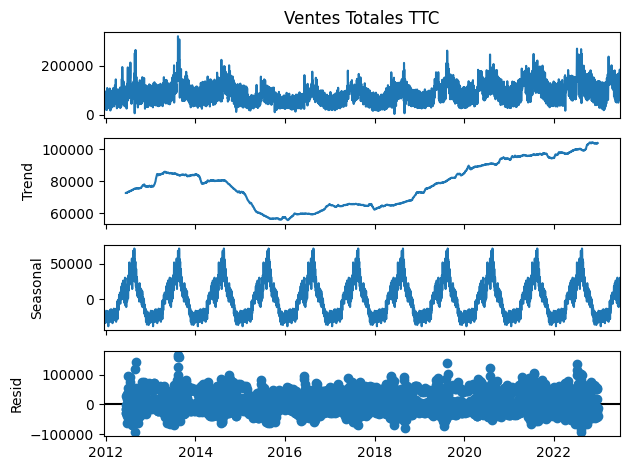

In [18]:
# @title Visualisation de ( trend & seasonality & resid)

ts = df['Ventes Totales TTC']


decomposition = seasonal_decompose(ts, model='additive', period=365)

fig = decomposition.plot()
plt.show()


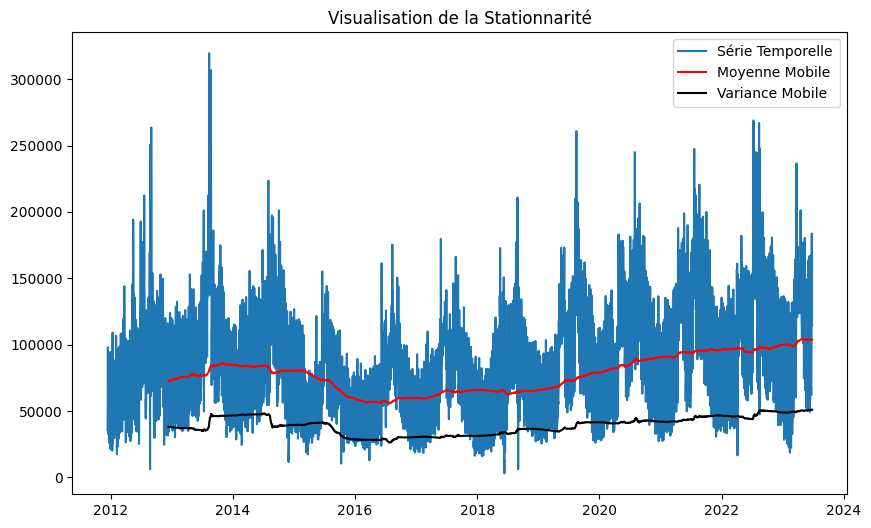

In [19]:
# @title Visualisation de la Stationnarité

ts = df['Ventes Totales TTC']

# Vérifier s'il y a des valeurs manquantes dans la série temporelle
if ts.isnull().any():
    print("Il y a des valeurs manquantes dans la série temporelle.")
else:

    # Calculer la moyenne mobile et la variance mobile
    rolling_mean = ts.rolling(window=365).mean()
    rolling_std = ts.rolling(window=365).std()



    plt.figure(figsize=(10, 6))
    plt.plot(ts, label='Série Temporelle')
    plt.plot(rolling_mean, color='red', label='Moyenne Mobile ')
    plt.plot(rolling_std, color='black', label='Variance Mobile ')
    plt.legend()
    plt.title('Visualisation de la Stationnarité')
    plt.show()

### ACF & PACF

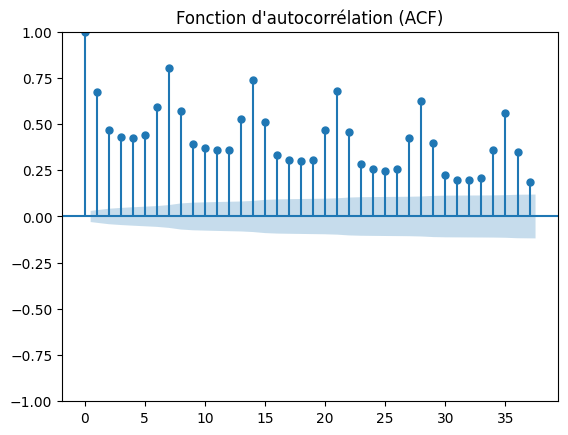

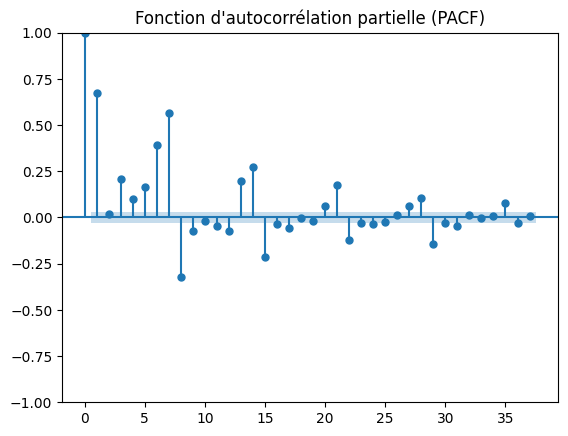

In [20]:
ts = df['Ventes Totales TTC']

# Tracez la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()

# Tracez la fonction d'autocorrélation partielle (PACF)
plot_pacf(ts)
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()



### ARMA MODEL

In [21]:

# @title  MODEL AR
from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(ts, order=(8, 0, 0))
model_ar_fit = model_ar.fit()

print(model_ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Ventes Totales TTC   No. Observations:                 4212
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -47952.527
Date:                Tue, 16 Apr 2024   AIC                          95925.053
Time:                        08:44:01   BIC                          95988.510
Sample:                    12-14-2011   HQIC                         95947.488
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.817e+04   6262.088     12.483      0.000    6.59e+04    9.04e+04
ar.L1          0.5172      0.008     68.581      0.000       0.502       0.532
ar.L2         -0.0585      0.010     -6.086      0.0

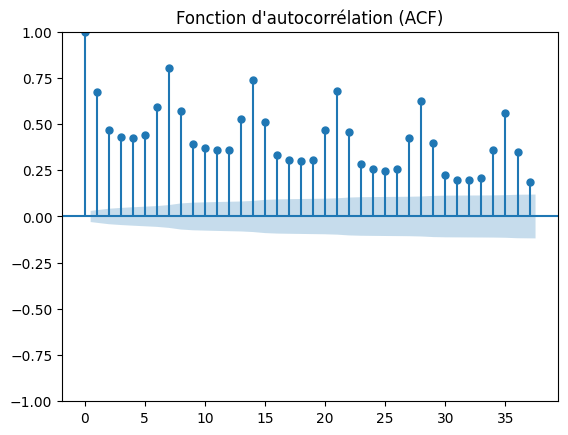

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# Tracer la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()


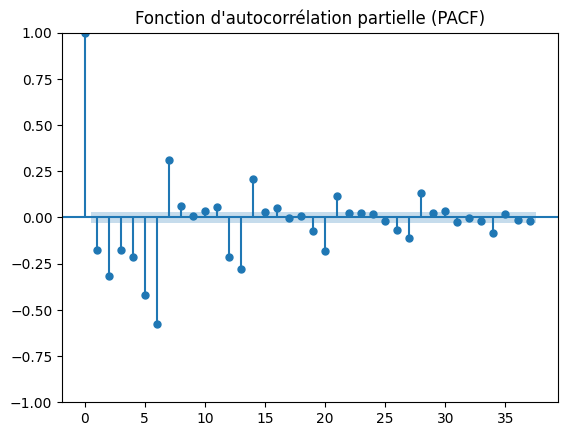

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(ts.diff().dropna())
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()



In [24]:
# @title  MODEL MA

model_ma = ARIMA(ts, order=(0, 0, 7))
model_ma_fit = model_ma.fit()


print(model_ma_fit.summary())


                               SARIMAX Results                                
Dep. Variable:     Ventes Totales TTC   No. Observations:                 4212
Model:                 ARIMA(0, 0, 7)   Log Likelihood              -49358.046
Date:                Tue, 16 Apr 2024   AIC                          98734.092
Time:                        08:44:11   BIC                          98791.203
Sample:                    12-14-2011   HQIC                         98754.283
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.817e+04   2629.024     29.733      0.000     7.3e+04    8.33e+04
ma.L1          0.4717      0.020     23.821      0.000       0.433       0.510
ma.L2          0.2025      0.021      9.452      0.0

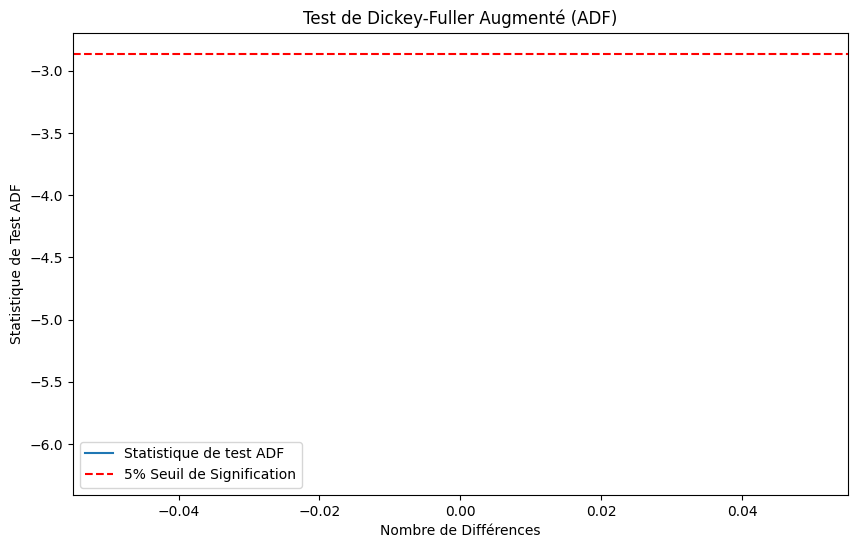

In [25]:
# @title ADF
result = adfuller(ts)

adf_stat = result[0]

plt.figure(figsize=(10, 6))
plt.plot(result[0], label='Statistique de test ADF')
plt.axhline(y=result[4]['5%'], color='r', linestyle='--', label='5% Seuil de Signification')
plt.title('Test de Dickey-Fuller Augmenté (ADF)')
plt.xlabel('Nombre de Différences')
plt.ylabel('Statistique de Test ADF')
plt.legend()
plt.show()


In [26]:


result = adfuller(ts)

# Extraire la statistique de test et la p-valeur
adf_stat = result[0]
p_value = result[1]


print(f'Statistique de test ADF : {adf_stat}')
print(f'p-valeur : {p_value}')


if p_value <= 0.05:
    print("La série temporelle est stationnaire ")
else:
    print("La série temporelle n'est pas stationnaire ")


Statistique de test ADF : -6.238824758548201
p-valeur : 4.752215015895043e-08
La série temporelle est stationnaire 


In [27]:
from statsmodels.tsa.arima.model import ARIMA

model_arma = ARIMA(ts, order=(8, 0, 7))
model_arma_fit = model_arma.fit()


print(model_arma_fit.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     Ventes Totales TTC   No. Observations:                 4212
Model:                 ARIMA(8, 0, 7)   Log Likelihood              -47323.466
Date:                Tue, 16 Apr 2024   AIC                          94680.931
Time:                        08:44:51   BIC                          94788.808
Sample:                    12-14-2011   HQIC                         94719.071
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.817e+04   4.88e-09    1.6e+13      0.000    7.82e+04    7.82e+04
ar.L1          0.4075      0.021     19.383      0.000       0.366       0.449
ar.L2         -0.0108      0.004     -2.869      0.0

In [28]:
# Prédictions sur l'ensemble de test avec ARMA
arma_predictions = model_arma_fit.predict(start=df_test.index[0], end=df_test.index[-1])


arma_predictions_series = pd.Series(arma_predictions, index=df_test.index)



In [29]:
# @title RMSE

arma_rmse = sqrt(mean_squared_error(df_test['Ventes Totales TTC'], arma_predictions_series))


arma_rmse_rounded = round(arma_rmse, 2)

print("RMSE pour ARMA:", arma_rmse_rounded)


RMSE pour ARMA: 14700.39


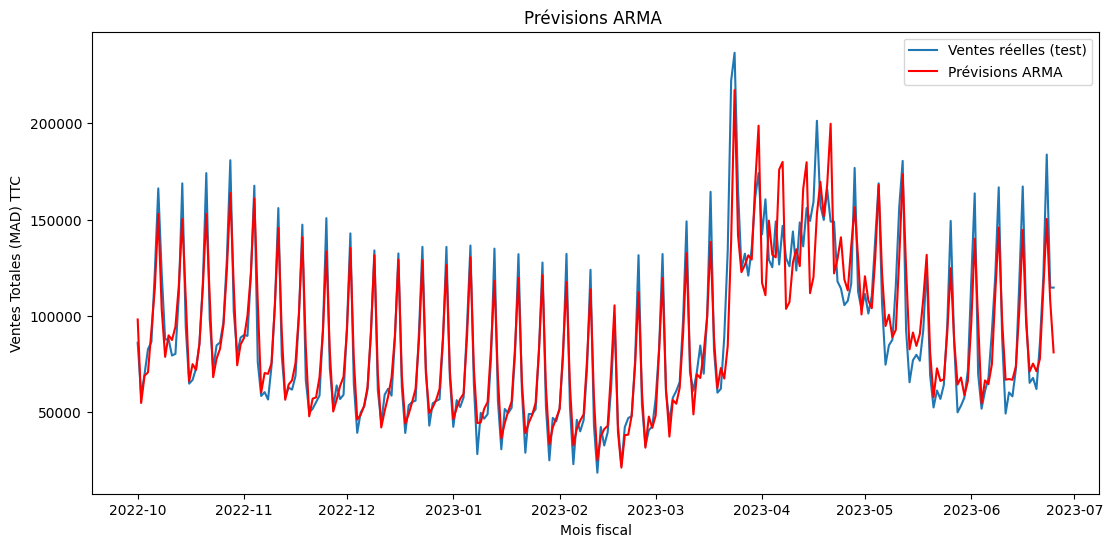

In [30]:

plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales TTC'], label='Ventes réelles (test)')
plt.plot(arma_predictions, label='Prévisions ARMA', color='red')
plt.title('Prévisions ARMA ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


### SARIMAX

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX


model_sarimax = SARIMAX(ts, order=(8, 0, 7), seasonal_order=(8, 0, 7, 365))


model_sarimax_fit = model_sarimax.fit()

print(model_sarimax_fit.summary())


In [ ]:
# Prédictions sur l'ensemble de test avec sarimax
sarimax_predictions = model_sarimax_fit.predict(start=df_test.index[0], end=df_test.index[-1])


sarimax_predictions_series = pd.Series(sarimax_predictions, index=df_test.index)



In [ ]:
# @title RMSE

sarimax_rmse = sqrt(mean_squared_error(df_test['Ventes Totales TTC'], sarimax_predictions_series))


sarimax_rmse_rounded = round(sarimax_rmse, 2)

print("RMSE pour sarimax:", sarimax_rmse_rounded)


### AUTO ARIMA


In [ ]:

auto_arima_model = auto_arima(ts, seasonal=True, m=365, trace=True)

print(auto_arima_model.summary())


### linear regression model

In [94]:
df_M = df.copy()

In [95]:
df_M_train = df_train.copy()
df_M_test = df_test.copy()

In [96]:
df_M[f'moving_avg_{3}'] = df_M['Ventes Totales TTC'].rolling(window=3).mean().shift(1)

In [97]:
df_M

,Ventes Totales TTC,moving_avg_3
Jour Fiscal,,
2011-12-14,35770.0,NaN
2011-12-15,51009.0,NaN
2011-12-16,97948.0,NaN
2011-12-17,36931.0,61575.666667
2011-12-18,32585.0,61962.666667
...,...,...
2023-06-21,85658.0,65046.666667
2023-06-22,119798.0,71841.666667
2023-06-23,183712.0,89165.666667


In [98]:
df_M[f'moving_avg_{6}'] = df_M['Ventes Totales TTC'].rolling(window=6).mean().shift(1)

In [99]:
df_M

,Ventes Totales TTC,moving_avg_3,moving_avg_6
Jour Fiscal,,,
2011-12-14,35770.0,NaN,NaN
2011-12-15,51009.0,NaN,NaN
2011-12-16,97948.0,NaN,NaN
2011-12-17,36931.0,61575.666667,NaN
2011-12-18,32585.0,61962.666667,NaN
...,...,...,...
2023-06-21,85658.0,65046.666667,96808.833333
2023-06-22,119798.0,71841.666667,91463.000000
2023-06-23,183712.0,89165.666667,83570.000000


In [100]:
df_M[f'moving_avg_{12}'] = df_M['Ventes Totales TTC'].rolling(window=12).mean().shift(1)

In [101]:
df_M

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12
Jour Fiscal,,,,
2011-12-14,35770.0,NaN,NaN,NaN
2011-12-15,51009.0,NaN,NaN,NaN
2011-12-16,97948.0,NaN,NaN,NaN
2011-12-17,36931.0,61575.666667,NaN,NaN
2011-12-18,32585.0,61962.666667,NaN,NaN
...,...,...,...,...
2023-06-21,85658.0,65046.666667,96808.833333,89693.666667
2023-06-22,119798.0,71841.666667,91463.000000,82939.750000
2023-06-23,183712.0,89165.666667,83570.000000,85543.666667


In [102]:
# @title Création des lag
df_M['sale_lastmonth'] = df_M['Ventes Totales TTC'].shift(1)
df_M['sale_3Monthsback'] = df_M['Ventes Totales TTC'].shift(3)
df_M['sale_6Monthsback'] = df_M['Ventes Totales TTC'].shift(6)
df_M['sale_12Monthsback'] = df_M['Ventes Totales TTC'].shift(12)

In [103]:
df_M["Date"] = df.index
df_M.head()

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,Date
Jour Fiscal,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011-12-15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011-12-16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011-12-17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011-12-18


In [104]:
df_M["year"] = df_M["Date"].dt.year
df_M["quarter"] = df_M["Date"].dt.quarter
df_M["month"] = df_M["Date"].dt.month

df_M["DAY"] = df_M["Date"].dt.day


df_M.head()


,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,Date,year,quarter,month,DAY
Jour Fiscal,,,,,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-14,2011,4,12,14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011-12-15,2011,4,12,15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011-12-16,2011,4,12,16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011-12-17,2011,4,12,17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011-12-18,2011,4,12,18


In [105]:
df_M.drop(columns=['Date'], inplace = True)

df_M.head()

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,year,quarter,month,DAY
Jour Fiscal,,,,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,4,12,14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011,4,12,15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011,4,12,16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011,4,12,17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011,4,12,18


In [106]:
df_M.dropna(inplace=True)


In [107]:
predict_start_date = df_M_test.index[0]
predict_end_date = df_M_test.index[-1]

In [108]:
# @title Variables indépendantes et dépendantes

X_train = df_M.loc[df_M.index < predict_start_date, df_M.columns != 'Ventes Totales TTC']
y_train = df_M.loc[df_M.index < predict_start_date, 'Ventes Totales TTC']

X_test = df_M.loc[(df_M.index >= predict_start_date) & (df_M.index <= predict_end_date), df_M.columns != 'Ventes Totales TTC']
y_test = df_M.loc[(df_M.index >= predict_start_date) & (df_M.index <= predict_end_date), 'Ventes Totales TTC']


In [109]:
# @title Linear Regression
lin_model = LinearRegression()

In [110]:
lin_model.fit(X_train, y_train)


LinearRegression()

In [111]:
predictions = lin_model.predict(X_test )

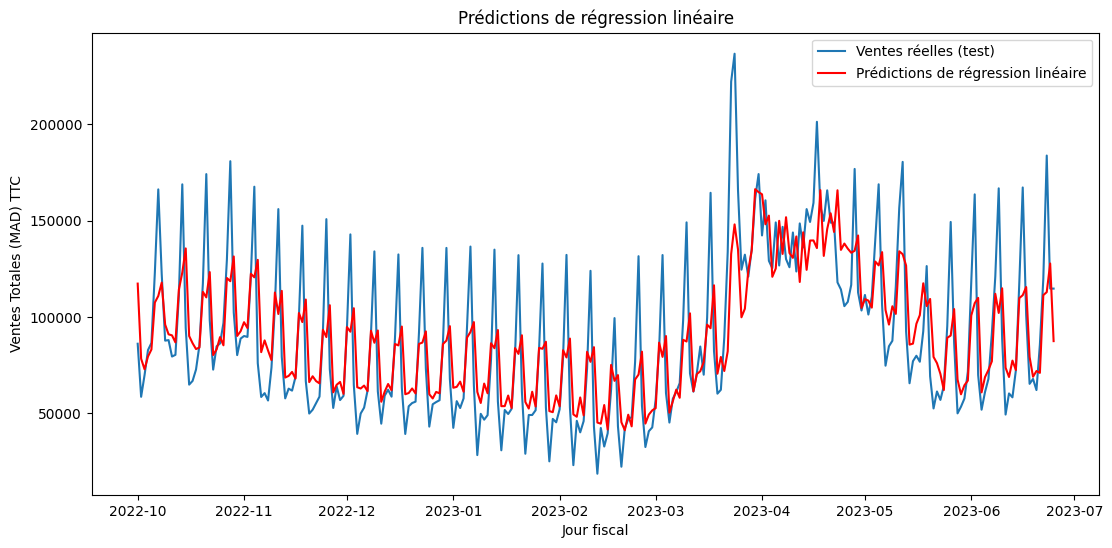

In [112]:
# @title Previsions Linear Regression
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, predictions, label='Prédictions de régression linéaire', color='red')

plt.title('Prédictions de régression linéaire')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


In [113]:
# @title Linear Regression RMSE
LinearRegression_rmse = mean_squared_error(y_test, predictions, squared=False)

Lin_rmse_rounded = round(LinearRegression_rmse, 2)
print(f'RMSE: {Lin_rmse_rounded}')

RMSE: 26636.04


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### RANDOM FOREST MODEL

In [114]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [115]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [116]:
rf_predictions = rf_model.predict(X_test)


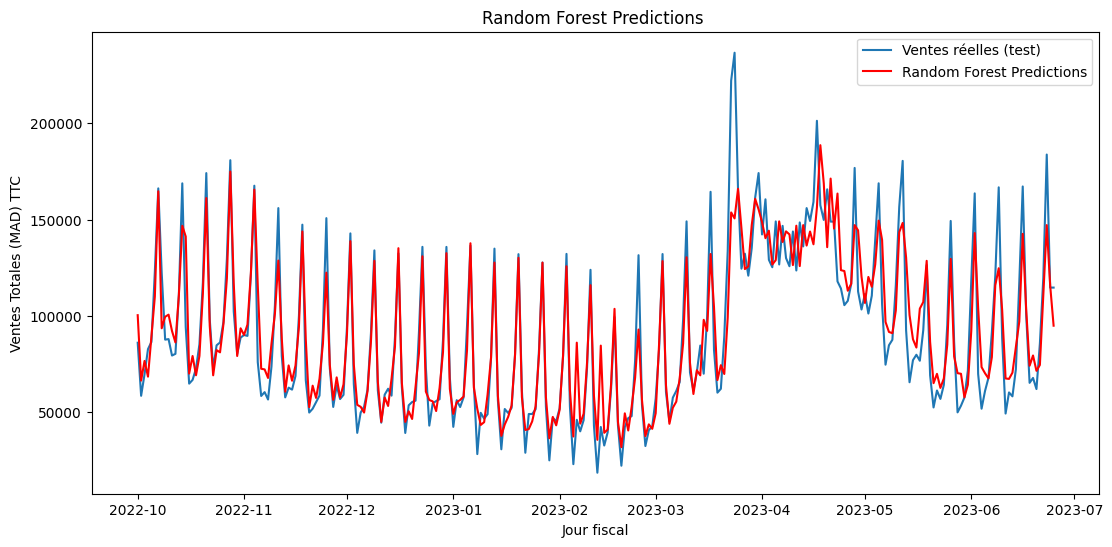

In [117]:
# @title Prévisions Random Forest
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='RED')

plt.title('Random Forest Predictions ')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [118]:
# @title Random Forest Regression RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
rf_rmse_rounded = round(rf_rmse, 2)
print(f'RMSE pour la forêt aléatoire : {rf_rmse_rounded}')

RMSE pour la forêt aléatoire : 16189.84


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### XG BOOST MODEL

In [119]:
# @title Convertir les données au format DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [120]:
# @title les paramètres du modèle XGBoost

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
    }

In [121]:
# @title Entraîner le modèle XGBoost
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)

In [122]:
# @title XGBoost Model Predictions
xgb_predictions = xgb_model.predict(dtest)

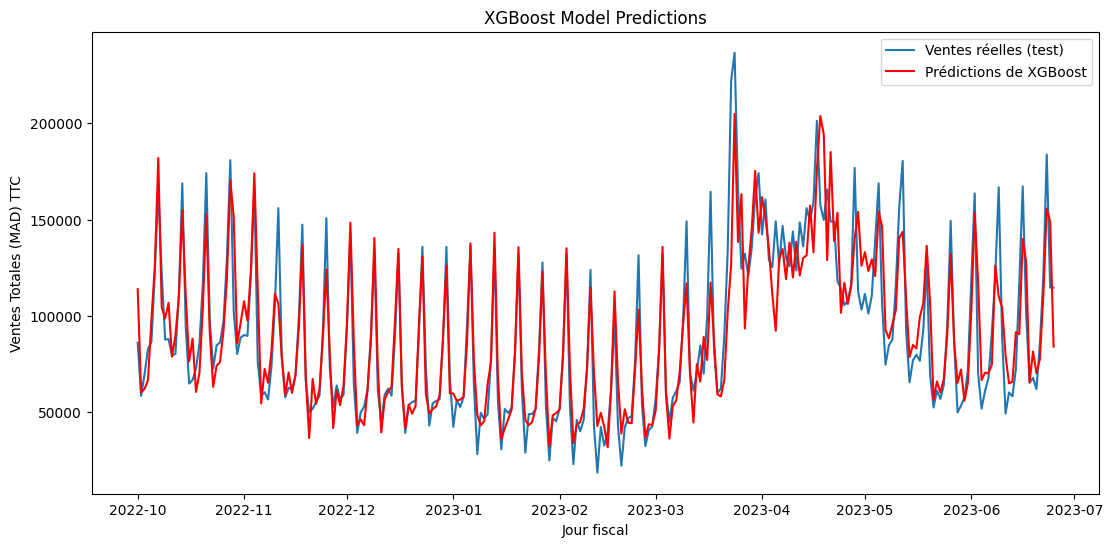

In [123]:


plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, xgb_predictions, label='Prédictions de XGBoost', color='red')

plt.title('XGBoost Model Predictions')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [124]:
# @title  RMSE pour XGBoost
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_rmse_rounded = round(xgb_rmse, 2)
print(f'RMSE pour XGBoost : {xgb_rmse_rounded}')

RMSE pour XGBoost : 17967.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


###Exponential Smoothing

In [126]:
# @title  Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


y_train = df_M_train['Ventes Totales TTC']

prediction_model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=365)


prediction_model = prediction_model.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)




<ipython-input-126-158535930b0a>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  prediction_model = prediction_model.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


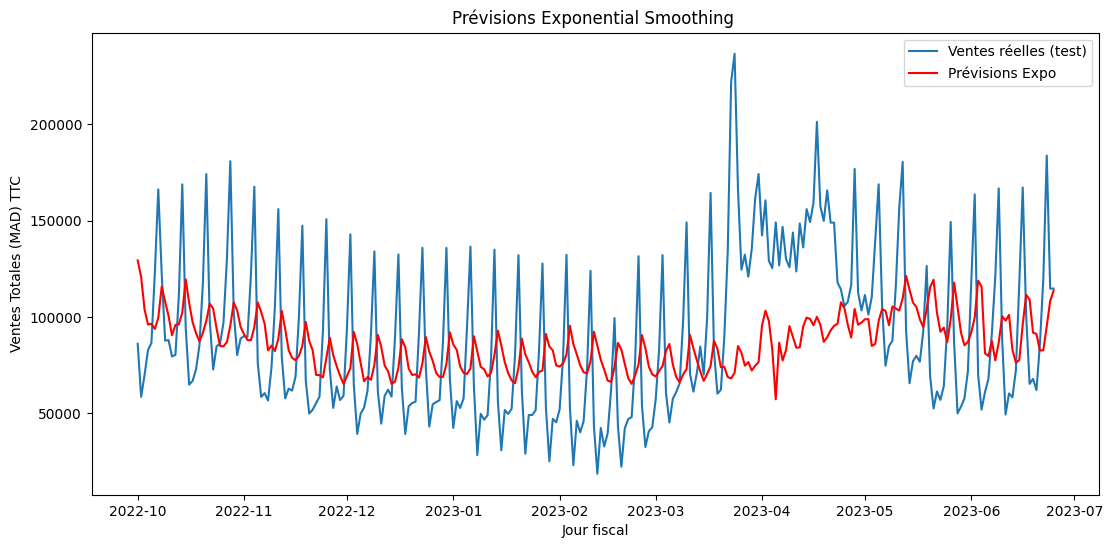

In [130]:
# @title Prévisions Exponential Smoothing

predictions = prediction_model.predict(start='2022-10-01', end='2023-06-25')


plt.figure(figsize=(13, 6))
plt.plot(df_M_test['Ventes Totales TTC'], label='Ventes réelles (test)')
plt.plot(predictions.index, predictions, label='Prévisions Expo', color='red')
plt.title('Prévisions Exponential Smoothing ')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()





In [131]:
expo_rmse = mean_squared_error(df_M_test['Ventes Totales TTC'], predictions, squared=False)
expo_rmse_rounded = round(expo_rmse, 2)
print(f'RMSE pour Expo Smoothing : {expo_rmse_rounded}')

RMSE pour Expo Smoothing : 42092.87


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### PROPHET

In [ ]:
# @title  PROPHET
from prophet import Prophet


model_prophet = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=10)
model_prophet.add_seasonality(name='DAILY', period=365, fourier_order=5)

df_prophet = df.reset_index().rename(columns={'Jour Fiscal': 'ds', 'Ventes Totales TTC': 'y'})


model_prophet.fit(df_prophet)



In [134]:
# @title Prévisions PROPHET
predi_start_date = df_M_test.index[0]
predi_end_date = df_M_test.index[-1]


data_test = df_prophet[(df_prophet['ds'] >= predi_start_date) & (df_prophet['ds'] <= predi_end_date)]

prd = model_prophet.predict(data_test)

prd_test = prd[(prd['ds'] >= predi_start_date) & (prd['ds'] <= predi_end_date)]



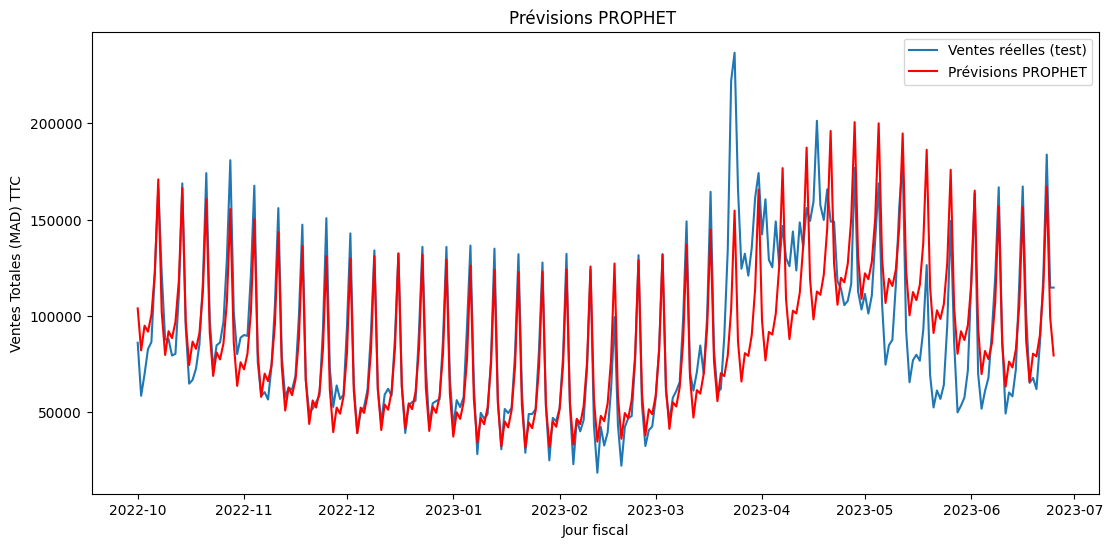

In [136]:
# @title Prévisions PROPHET
plt.figure(figsize=(13, 6))
plt.plot(df_M_test['Ventes Totales TTC'], label='Ventes réelles (test)')
plt.plot(prd_test['ds'], prd_test['yhat'], label='Prévisions PROPHET', color='red')
plt.title('Prévisions PROPHET ')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [138]:
# @title RMSE PROPHET

merged_df = pd.merge(df_M_test, prd, left_on='Jour Fiscal', right_on='ds', how='inner')


prophet_predictions_series = merged_df['yhat']


actual_values = merged_df['Ventes Totales TTC']


prophet_rmse = sqrt(mean_squared_error(actual_values, prophet_predictions_series))
prophet_rmse_rounded = round(prophet_rmse, 2)

print("RMSE pour Prophet:", prophet_rmse_rounded)



RMSE pour Prophet: 22682.19


### COMPARAISON DES MODELS

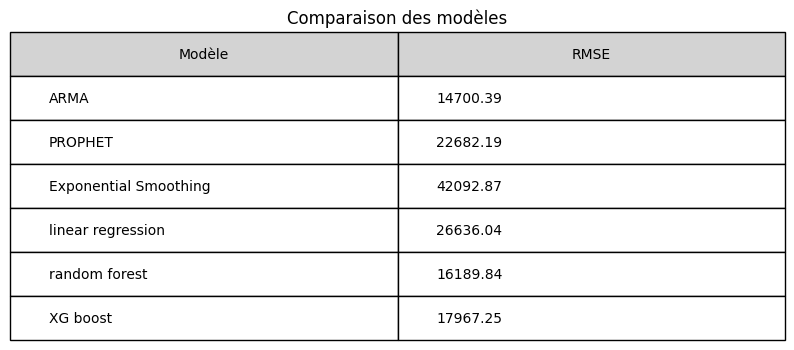


Le modèle le plus performant est: ARMA avec un RMSE de: 14700.39 


In [139]:

results = {
    "Modèle": ["ARMA", "PROPHET" , "Exponential Smoothing", "linear regression", "random forest" , "XG boost"],
    "RMSE": [arma_rmse_rounded,prophet_rmse_rounded,expo_rmse_rounded, Lin_rmse_rounded,rf_rmse_rounded , xgb_rmse_rounded]
}

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Modèle']
best_rmse = results_df['RMSE'].min()


fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
ax.set_title('Comparaison des modèles')

table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 bbox=[0, 0, 1, 1],
                 cellLoc='left',
                 colColours=['lightgrey']*len(results_df.columns))


plt.show()


print()


print("\033[1mLe modèle le plus performant est:", best_model, "avec un RMSE de:", best_rmse, "\033[0m")
